# The intent of this notebook is to familiarize ourselves with the data, do some exploratory analysis and to construct timeseries and other data for further analysis by the team

In [97]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import datetime
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

#set default plot characterstics and colors
from matplotlib import rcParams

import prep_data

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 8)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# import findspark
# findspark.init()
# import pyspark
# sc = pyspark.SparkContext(appName="Spark1")

### Loading the data with some initial cleaning (h/t CS109Hubway for getting me started on this and for having the data loaded to github already)

In [5]:
stations_df = prep_data.stations('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/hubway_stations.csv')
stations_df.head()

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


In [6]:
stations_df.shape

(142, 7)

In [7]:
station_ids = stations_df['id'].unique()

In [8]:
trips_df = prep_data.trips('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/tripsthrough2012.csv')
trips_df.head()

,index,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,...,st_hour,end_hour,st_minute,end_minute,st_month,end_month,st_daydate,end_daydate,st_weekday,end_weekday
0,140521,140522,157655,Closed,189,2012-03-13 18:31:00,29,2012-03-13 18:34:00,18,B00094,...,18,18,1111,1114,3,3,2012-03-13,2012-03-13,1,1
1,140522,140524,157657,Closed,704,2012-03-15 00:00:00,40,2012-03-15 00:12:00,40,B00082,...,0,0,0,12,3,3,2012-03-15,2012-03-15,3,3
2,140523,140523,157656,Closed,1700,2012-03-15 00:00:00,7,2012-03-15 00:28:00,15,B00603,...,0,0,0,28,3,3,2012-03-15,2012-03-15,3,3
3,140524,140525,157658,Closed,1411,2012-03-15 00:00:00,41,2012-03-15 00:24:00,36,B00278,...,0,0,0,24,3,3,2012-03-15,2012-03-15,3,3
4,140525,140526,157659,Closed,251,2012-03-15 00:03:00,43,2012-03-15 00:07:00,40,B00076,...,0,0,3,7,3,3,2012-03-15,2012-03-15,3,3


In [9]:
# Assign Time Periods:
# 1: Morning (4am-12pm)
# 2: Afternoon (12pm-8pm)
# 3: Evening (8pm-4am)
time_periods = np.zeros(len(trips_df))
start_dates = trips_df['start_date'].values
for i in xrange(len(start_dates)):
    hour = pd.Timestamp(start_dates[i]).time().hour
    if 4 <= hour and hour < 12:
        #morning
        time_period = 1
    elif 12 <= hour and hour < 20:
        # afternoon
        time_period = 2
    else:
        # evening 
        time_period = 3
    time_periods[i] = time_period

In [10]:
trips_df['time_period'] = time_periods
trips_df.head()

,index,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,...,end_hour,st_minute,end_minute,st_month,end_month,st_daydate,end_daydate,st_weekday,end_weekday,time_period
0,140521,140522,157655,Closed,189,2012-03-13 18:31:00,29,2012-03-13 18:34:00,18,B00094,...,18,1111,1114,3,3,2012-03-13,2012-03-13,1,1,2
1,140522,140524,157657,Closed,704,2012-03-15 00:00:00,40,2012-03-15 00:12:00,40,B00082,...,0,0,12,3,3,2012-03-15,2012-03-15,3,3,3
2,140523,140523,157656,Closed,1700,2012-03-15 00:00:00,7,2012-03-15 00:28:00,15,B00603,...,0,0,28,3,3,2012-03-15,2012-03-15,3,3,3
3,140524,140525,157658,Closed,1411,2012-03-15 00:00:00,41,2012-03-15 00:24:00,36,B00278,...,0,0,24,3,3,2012-03-15,2012-03-15,3,3,3
4,140525,140526,157659,Closed,251,2012-03-15 00:03:00,43,2012-03-15 00:07:00,40,B00076,...,0,3,7,3,3,2012-03-15,2012-03-15,3,3,3


In [11]:
del time_periods
del start_dates

In [12]:
# Create masks for each time period
morning_mask = trips_df['time_period'] == 1
afternoon_mask = trips_df['time_period'] == 2
evening_mask = trips_df['time_period'] ==3

In [13]:
# Let K = maxmimum id of a station
K = stations_df.id.max()

In [14]:
# drop rows with NAs
trips_df.dropna(axis=0,inplace=True)

In [15]:
mini_trips = trips_df.loc[:,["strt_statn","end_statn","time_period"]]
transition_matrix = np.zeros([146,146,3])
for index, row in mini_trips.dropna(axis=0).iterrows():
    print "\r" + str(index) + " " + str(row[0]) + " " + str(row[1]),
    transition_matrix[row[0],row[1],row[2]-1] += 1
for period in range(3):
    for i in range(146):
        transition_matrix[i,:,period] = transition_matrix[i,:,period] / np.sum(transition_matrix[i,:,period])

408764 55.0 45.0


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [16]:
sum(transition_matrix[4,:,1])

1.0000000000000004

In [17]:
# Create distance and duration matrices

trips_df["trip_duration"] = trips_df["end_minute"] - trips_df['st_minute']
mini_trips = trips_df.loc[:,["strt_statn","end_statn","trip_duration"]]
mini_trips = mini_trips.dropna(axis=0)
duration_matrix = np.zeros([max(stations_df.id)+1,max(stations_df.id)+1])
counter_matrix = np.zeros([max(stations_df.id)+1,max(stations_df.id)+1])
distance_matrix = np.zeros([max(stations_df.id)+1,max(stations_df.id)+1])
# create duration matrix
for index, row in mini_trips.iterrows():
    print "\r" + str(index) + " " + str(row[0]) + " " + str(row[1]),
    if row[2] > 0:
        duration_matrix[row[0],row[1]] += row[2]
        counter_matrix[row[0],row[1]] += 1.0

duration_matrix /= counter_matrix
# create distance matrix
for index, row in stations_df.iterrows():
    for index2, row2 in stations_df.iterrows():
        print "\r" + str(row[0]) + " " + str(row2[0]),
        station1 = row[0]
        station2 = row2[0]
        phi1 = row[4]*np.pi/180.
        phi2 = row2[4]*np.pi/180.
        lam1 = row[5]*np.pi/180.
        lam2 = row2[5]*np.pi/180.
        delphi = np.abs(phi1 - phi2)
        dellam = np.abs(lam1 - lam2)
        delsig = np.arccos(np.sin(phi1)*np.sin(phi2)+np.cos(phi1)*np.cos(phi2)*np.cos(dellam))
        r = 3959 #mi
        distance_matrix[station1,station2] = r*delsig    

145 145


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [18]:
# Get probability that there is a rider at a given station at a given time period
rides = np.zeros((3,max(stations_df.id)+1))
for index, row in trips_df.iterrows():
    print "\r" + str(index) + " " + str(row[6]) + " " + str(row[-2]),
    rides[row[-2]-1,row[6]] += 1

408764 55.0 3.0


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [19]:
# Simulated Annealing

In [20]:
# create a new initial bike positions
# returns the new starting positions
def change_mapping(bike_start_locs,num_to_move):
    # make copy
    proposed_bike_start_locs = np.copy(bike_start_locs)
    # Choose which bike to move
    bikes_to_move = np.random.choice(np.arange(len(bike_start_locs)),replace=False,size=num_to_move)
    for bike_idx in bikes_to_move:
        # choose where to move bike to
        move_bike_to = np.random.randint(3,K+1)
        proposed_bike_start_locs[bike_idx] = move_bike_to
    return proposed_bike_start_locs

In [21]:
distance_matrix[4]

array([ 0.        ,  0.        ,  0.        ,  1.6358965 ,         nan,
        1.07888842,  1.12170066,  1.39137601,  3.50034323,  2.41254234,
        1.88018687,  1.94085954,  1.16575924,  0.81502131,  1.78733169,
        3.66949683,  0.36287488,  2.89114259,  3.31429815,  1.85518531,
        1.35398022,  0.66312296,  0.85782202,  1.11729445,  1.31108118,
        0.46376896,  0.26974636,  1.59950513,  0.        ,  3.07873279,
        1.97956296,  1.44295096,  1.66828982,  1.41257342,  1.54522985,
        0.83689796,  0.49153385,  4.00823068,  1.50761745,  0.52263233,
        1.59559805,  2.80899066,  0.46486176,  1.26191961,  1.2351267 ,
        1.44410005,  0.83921905,  1.38828494,  1.06908603,  0.43236835,
        0.43804085,  0.87321768,  0.8654115 ,  1.1017259 ,  0.73571529,
        0.95218477,  1.38030881,  0.68816397,  0.72334755,  0.66615469,
        1.073467  ,  0.69693015,  2.08862131,  0.648483  ,  1.09562123,
        1.31119233,  3.29600356,  1.4903564 ,  2.1845033 ,  2.75

([array([ 146.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 146.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0

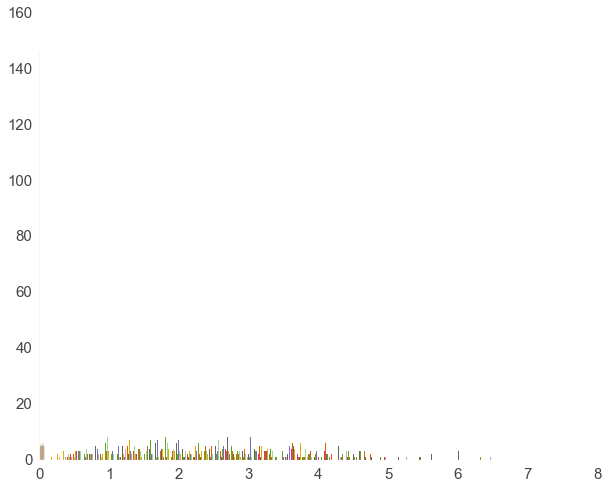

In [22]:
plt.hist(distance_matrix,bins=100)

In [23]:
from scipy.stats import poisson
def runday(proposed_bike_start_locs, interval, ride_probs):
    # Initialize matrix to store bike data (changing each interval)
    # 0th column is whether the bike is in transit (1= in transit)
    # 1st col is time left in transit
    # 2nd column is location
    # 3rd column is total distance for bike in day
    bikes = np.zeros((len(proposed_bike_start_locs),4))
    #intial time
    t = 0
    bikes[:,2] = proposed_bike_start_locs
    morning_begin = 240
    afternoon_begin = 720
    evening_begin = 1200
    while t < 1440:
        #determine current time period:
        current_hour = t % 60
        time_period = 2
        if current_hour >= 4 and current_hour < 12:
            time_period = 0
        elif current_hour >=12 and current_hour < 20:
            time_period = 1
        # for each station draw number of riders that show up from poisson dist with
        # parameter expected number of riders in that time period, interval, station
        num_riders = poisson.rvs(ride_probs[time_period]+10**(-10))
        for i in xrange(bikes.shape[0]):
            bike = bikes[i]
            if bike[0] == 1:
                # in transit
                bike[1] -= interval
                if bike[1] <= 0:
                    # if time left is zero
                    #then bike is not in transit
                    bike[0] = 0
            else:
                # not in transit
                if num_riders[bike[2]] > 0:
                    # rider takes the bike
                    num_riders[bike[2]] -= 1
                    # store prev location
                    prev_loc = bike[2]
                    # pick destination
                    bike[2] = np.random.choice(np.arange(0,K+1),p=transition_matrix[prev_loc,:,time_period])
                    #update duration
                    bike[1] = duration_matrix[prev_loc,bike[2]]
                    #update distance
                    ride_dist = min(2,distance_matrix[prev_loc,bike[2]])
                    # battery capacity is full after two miles
#                     bike[3] += distance_matrix[prev_loc,bike[2]]
                    bike[3] += ride_dist
                    bike[0] = 1
        t += interval
    return np.sum(bikes[:,3])

In [85]:
# function for simulated annealing
# x: points1
# y: points2
# w: array of weights
# v: array of values
# total_weight_limit: total weight limit
# init_temp: initial temperature 
# thermostat: linear factor to decrease the temperature 
# ftol, itol: tolerance values for stopping 
# ftol: Not changing much anymore --> function tolerance threshold
# itol: maximum number of iterations
# reannealing: schedule for reheating

def simulated_annealing(init_temp, thermostat, ftol, itol, reannealing,num_bikes,interval):
    # number of iterations before stopping
    # if improvment is less than function tolerance, typically m = 100
    m=100
    
    # initialize correspondence matrix with random mappings
    bike_start_locs = np.random.randint(3,K+1,size=num_bikes)
    # array storing the norm at each step
    total_dists = []
    
    # initialize temperature
    temperature = init_temp   

    # number of accepted steps
    it = 0                    
    A = np.zeros((3,3))
    # Energy is the norm
    prev_dist = 0
    # number of iterations
    atp=0
    
    # keep track of most valuable knapsack
    best_bike_start_locs = np.copy(bike_start_locs)
    best_dist = prev_dist
    
    # get expected number of interested riders per station per interval in the given time period
    ride_probs = rides/8.0/60.0*interval
    
    while it >= 0:
        # adaptive step size 
        num_to_move = np.max((np.floor(temperature).astype(int),2))
        num_to_move = np.min((num_bikes, num_to_move))

        #num_to_move = 2
        proposed_bike_start_locs = change_mapping(bike_start_locs,num_to_move)
        
        # make energy negative, so we minimize energy
        new_dist = runday(proposed_bike_start_locs,interval,ride_probs)
        delta_dist =  new_dist - prev_dist 

        if new_dist > prev_dist:
            bike_start_locs = proposed_bike_start_locs
            total_dists.append(new_dist)
            prev_dist = new_dist 
            it = it+1
            
        elif np.random.rand() < np.exp( delta_dist/temperature):
            bike_start_locs = proposed_bike_start_locs
            total_dists.append(new_dist)
            prev_dist = new_dist
            it = it+1
        
        # Store most valuable knapsack
        if new_dist > best_dist:
            best_bike_start_locs = np.copy(proposed_bike_start_locs)
            best_dist = new_dist
            
        atp = atp +1  # NUMBER OF ITERATIONS
        
        # check if it is time to cool down
        if it % reannealing == 0:
            temperature = thermostat * temperature
            compl_temp=0
            
            #if we get too cold, reheat
            if temperature < 1:
                temperature = 10
                
        if len(total_dists)>m and np.std(total_dists[-m:])/np.mean(total_dists[-m:]) < ftol:
            print 'ftol'
            break
        if atp >itol:
            print 'itol'
            break
        print '\r'+str(np.round(float(it)/atp,decimals=2)) + " " + str(atp) + " " + str(it),

    return best_bike_start_locs, best_dist

In [86]:
init_temp =100
num_bikes = 50
thermostat = .9
ftol = .01
itol = 100000
reannealing =1000
interval = 10
best_bike_start_locs,best_dist = simulated_annealing(init_temp, thermostat, ftol, itol, reannealing,num_bikes,interval)
print sorted(best_bike_start_locs)
print best_dist

0.04 100000 4029 itol
[3, 7, 8, 9, 11, 11, 12, 13, 14, 17, 18, 21, 21, 24, 24, 24, 27, 31, 33, 35, 35, 35, 36, 45, 45, 46, 47, 47, 49, 50, 52, 54, 54, 56, 56, 58, 60, 64, 67, 70, 74, 77, 78, 78, 80, 87, 88, 95, 97, 97]
2736.79252183


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


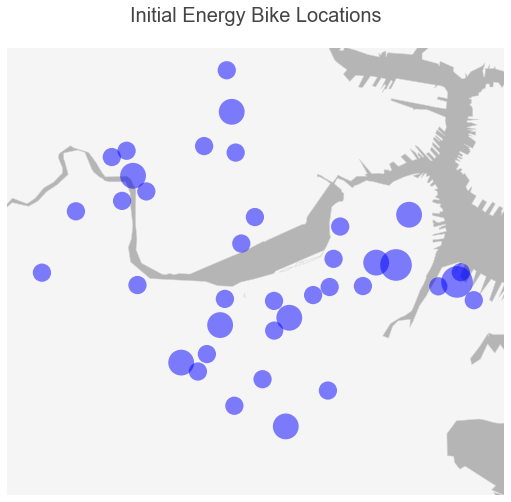

In [98]:
def stationmap(stations_df, start_loc_counts,filedir=None, savefig=False):
    # start_loc_counts is a dictionary of location --> number of bikes starting there
    time_title = str(hour)+" AM" if hour < 12 else str(hour)+" PM" if hour == 12 else str(hour%12)+" PM"
    img_num = str(hour+1)
    while len(img_num)<3:
        img_num = "0"+img_num


    #get list of stations, get their latitudes and longitudes, and store in list
    start_df = stations_df[stations_df['id'].isin(start_loc_counts.keys())]
    latlistin =start_df.lat.tolist()
    lonlistin =start_df.lng.tolist()

    #scale stations to emphasise relative numbers of in and out trips
    counts = start_loc_counts.values()
    scales = [n *2.0 / (max(counts) *1.0 )* 500.0 for n in counts]

    #set up plot with mercator projection and coastline for context
    #plt.subplots(1,2,figsize=(19,12))
    #plt.subplot(1, 2, 1)
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m.drawmapboundary(fill_color='#F5F5F5',  linewidth=0)
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    # compute the native map projection coordinates for stations
    xout,yout = m(lonlistin,latlistin)

    #plot trip departures using scaled circles at the station locations
    m.scatter( xout, yout,  c='blue', s=scales, marker='o', alpha=0.5,zorder = 2, )
    plt.title('Initial Energy Bike Locations\n')
    '''
    #set up plot with mercator projection and coastline for context
    plt.subplot(1, 2, 2)
    m2=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m2.drawmapboundary(fill_color='#F5F5F5', linewidth=0)
    m2.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m2.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    # compute the native map projection coordinates for stations
    xin,yin = m(lonlistin,latlistin)

    #plot trip departures using scaled circles at the station locations
    m2.scatter( xin, yin,  c='red', s=tripsin, marker='o', zorder = 2, alpha=0.5)
    plt.title('Weekend Hubway Arrivals at ' + time_title + '\n')
    '''
    if savefig:
        return plt.savefig(filedir+'/figure' + img_num)
    else:
        return plt.show()

#Create dictionary of location => number bikes starting there
start_loc_counts = dict()
for loc in best_bike_start_locs:
    if loc in start_loc_counts:
        start_loc_counts[loc] += 1
    else:
        start_loc_counts[loc] = 1
stationmap(stations_df, start_loc_counts,filedir=None, savefig=False)